# Simulation result analysis for cost valley weights study

## Section I, trajectory analysis

In [1]:
from Config import Config
from usr_func.checkfolder import checkfolder
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from matplotlib.gridspec import GridSpec

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20

filepath = "./npy/CV/"
print(os.listdir(filepath))

c = Config()
plg_b = c.get_polygon_border()
plg_o = c.get_polygon_obstacle()


['P4', 'P3', 'P2', 'P5', '.DS_Store', 'IBV.npy', 'VR.npy', 'TRAJ.npy', 'P1', 'RMSE.npy']


In [2]:
figpath = "./../../fig/Sim_2DNidelva/Cases/"
d_traj = np.load(filepath + "TRAJ.npy")
d_ibv = np.load(filepath + "IBV.npy")
d_vr = np.load(filepath + "VR.npy")
d_rmse = np.load(filepath + "RMSE.npy")
print(os.listdir(figpath))

['P4', 'P3', 'P_009.png', 'P_008.png', 'P_020.png', 'P2', 'P_018.png', '.DS_Store', 'P_019.png', 'P1', 'P_003.png', 'P_017.png', 'P_016.png', 'P_002.png', 'P_014.png', 'P_000.png', 'P_001.png', 'P_015.png', 'P_011.png', 'P_005.png', 'P_004.png', 'P_010.png', 'P_006.png', 'P_012.png', 'P_013.png', 'P_007.png']


In [15]:
d_traj.shape

(50, 3, 81, 2)

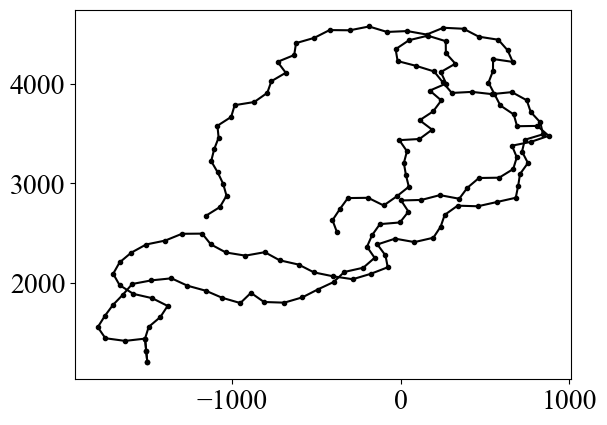

In [6]:
plt.plot(d_traj[0, 0, :, 1], d_traj[0, 0, :, 0], 'k.-')
plt.plot(d_traj[10, 0, :, 1], d_traj[10, 0, :, 0], 'k.-')



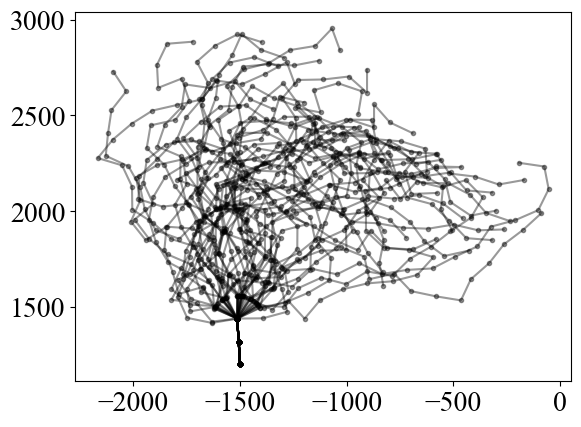

In [29]:
def plotf(i, title):
    fig = plt.figure(figsize=(40, 12))
    gs = GridSpec(nrows=1, ncols=3)
    for j in range(d_traj.shape[0]):
        ax = fig.add_subplot(gs[0])
        ax.plot(d_traj[j, 0, :i, 1], d_traj[j, 0, :i, 0], 'k.-', alpha=.4)
#         ax.plot(d_traj[j, 0, :i, 1], d_traj[j, 0, :i, 0], 'k.-', alpha=.1)
#         ax.plot(plg_b[:, 1], plg_b[:, 0], 'r-.')
#         ax.plot(plg_o[:, 1], plg_o[:, 0], 'r-.')
#         ax.set_xlabel("East")
#         ax.set_ylabel("North")
#         ax.set_title("EIBV dominant")
#         ax.set_aspect("equal")

        
        ax = fig.add_subplot(gs[1])
#         ax.plot(data[j, 1, :i, 1], data[j, 1, :i, 0], 'k.-', alpha=.1)
#         ax.plot(plg_b[:, 1], plg_b[:, 0], 'r-.')
#         ax.plot(plg_o[:, 1], plg_o[:, 0], 'r-.')
#         ax.set_xlabel("East")
#         ax.set_ylabel("North")
#         ax.set_title("Equal weights")
#         ax.set_aspect("equal")
        
        ax = fig.add_subplot(gs[2])
#         ax.plot(data[j, 2, :i, 1], data[j, 2, :i, 0], 'k.-', alpha=.1)
#         ax.plot(plg_b[:, 1], plg_b[:, 0], 'r-.')
#         ax.plot(plg_o[:, 1], plg_o[:, 0], 'r-.')
#         ax.set_xlabel("East")
#         ax.set_ylabel("North")
#         ax.set_title("IVR dominant")
#         ax.set_aspect("equal")

    plt.show()

#     plt.savefig(figpath + "P_{:03d}.png".format(i))
#     plt.close("all")

# for i in tqdm(range(d_traj.shape[2])):
#     print("i: ", i)
#     plotf(d_traj, i, "")
#     if i > 3: 
#         break
i = d_traj.sha
# plotf(i, "")

for j in range(d_traj.shape[0]):
#     print(j)
    plt.plot(d_traj[j, 0, :i, 1], d_traj[j, 0, :i, 0], 'k.-', alpha=.4)
plt.show()


In [ ]:
pb = c.get_polygon_border()
po = c.get_polygon_obstacle()

In [ ]:
s1 = np.load(filepath + "eibv_ivr_1.90_0.10.npy")
s2 = np.load(filepath + "eibv_ivr_0.10_1.90.npy")
s3 = np.load(filepath + "eibv_ivr_1.00_1.00.npy")

def plotf(s, i): 
    plt.plot(pb[:, 1], pb[:, 0], 'r-.')
    plt.plot(po[:, 1], po[:, 0], 'r-.')
    for j in range(s.shape[0]):
        plt.plot(s[j, :i, 1], s[j, :i, 0], 'k.-', alpha=.1)
    plt.gca().set_aspect('equal')
    plt.xlabel("East")
    plt.ylabel("North")
#     plt.title("Iteration: " + str(i))

for i in tqdm(range(s1.shape[1])):

    fig = plt.figure(figsize=(30, 10))
    gs = GridSpec(nrows=1, ncols=3)
    ax = fig.add_subplot(gs[0])
    plotf(s1, i)
    ax.set_title("EIBV: {:.2f}, IVR: {:.2f}".format(1.9, .1))

    ax = fig.add_subplot(gs[1])
    plotf(s2, i)
    ax.set_title("EIBV: {:.2f}, IVR: {:.2f}".format(.1, 1.9))

    ax = fig.add_subplot(gs[2])
    plotf(s3, i)
    ax.set_title("EIBV: {:.2f}, IVR: {:.2f}".format(1., 1.))

    plt.savefig(figpath + "P_{:03d}.png".format(i))
    plt.close("all")
#     plt.show()
#     if i == 2: 
#         break

## Section II, metric analysis

In [12]:
d_ibv.shape

(50, 3, 81)

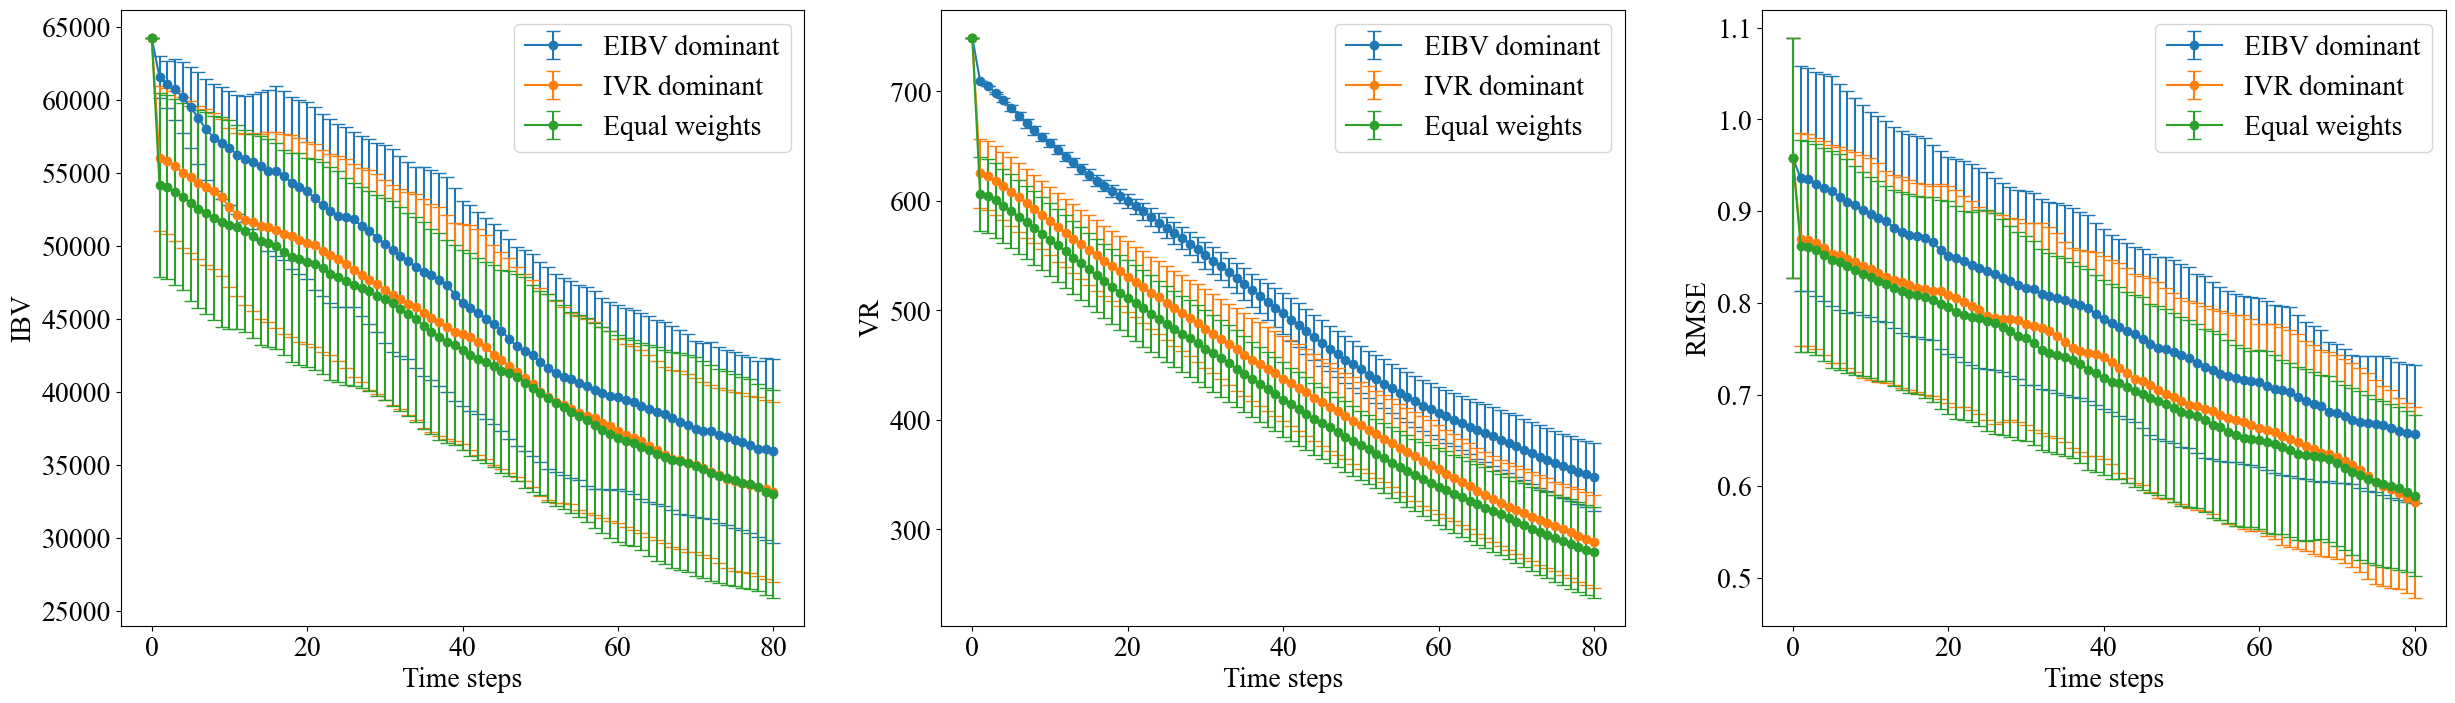

In [14]:
fig = plt.figure(figsize=(30, 8))
gs = GridSpec(nrows=1, ncols=3)

def plotf_sim(data, ylabel="IBV", counter=0):
    N = data.shape[0]
    hx = np.arange(data.shape[-1])

    ax = fig.add_subplot(gs[counter])
    ax.errorbar(hx, y=np.mean(data[:, 0, :], axis=0), yerr=np.std(data[:, 0, :], axis=0), fmt="-o", capsize=5,
                         label="EIBV dominant")
    ax.errorbar(hx, y=np.mean(data[:, 2, :], axis=0), yerr=np.std(data[:, 2, :], axis=0), fmt="-o", capsize=5,
                         label="IVR dominant")
    ax.errorbar(hx, y=np.mean(data[:, 1, :], axis=0), yerr=np.std(data[:, 1, :], axis=0), fmt="-o", capsize=5,
                         label="Equal weights")
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel(ylabel)

plotf_sim(d_ibv, "IBV", 0)
plotf_sim(d_vr, "VR", 1)
plotf_sim(d_rmse, "RMSE", 2)


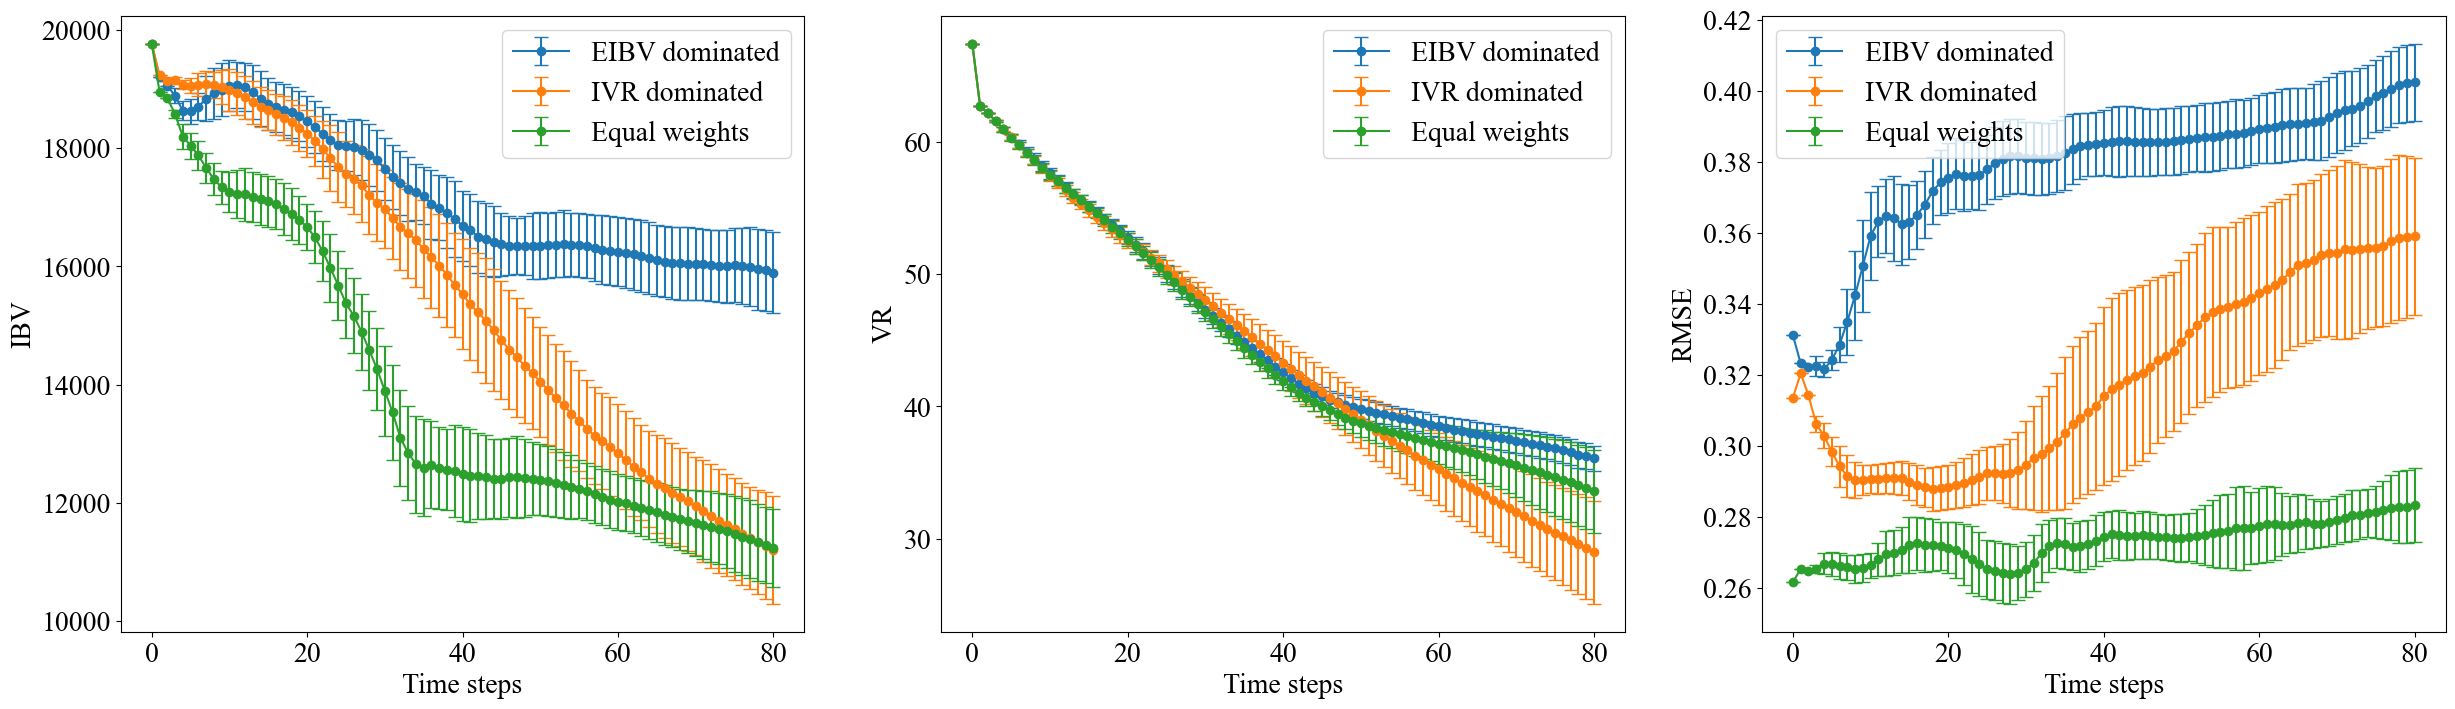

In [28]:
fig = plt.figure(figsize=(30, 8))
gs = GridSpec(nrows=1, ncols=3)
counter = 0

for metric in metrics:
    d_eibv = np.load(filepath + "../EIBV_" + metric + ".npy")
    d_ivr = np.load(filepath + "../IVR_" + metric + ".npy")
    d_eq = np.load(filepath + "../EQUAL_" + metric + ".npy")

    N = d_eibv.shape[0]
    hx = np.arange(d_eibv.shape[1])
    
    ax = fig.add_subplot(gs[counter])
    ax.errorbar(hx, y=np.mean(d_eibv, axis=0), yerr=np.std(d_eibv, axis=0), fmt="-o", capsize=5,
                         label="EIBV dominated")
    ax.errorbar(hx, y=np.mean(d_ivr, axis=0), yerr=np.std(d_ivr, axis=0), fmt="-o", capsize=5,
                         label="IVR dominated")
    ax.errorbar(hx, y=np.mean(d_eq, axis=0), yerr=np.std(d_eq, axis=0), fmt="-o", capsize=5,
                         label="Equal weights")
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel(metric.upper())

    counter += 1



In [10]:
d_ibv.shape

(50, 3, 81)